In [ ]:
# TODO: Read: chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://arxiv.org/pdf/2309.11798v4
# and https://www.nature.com/articles/s41598-024-58624-4 and https://www.nature.com/articles/s41598-024-58624-4
# chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://www.aimspress.com/aimspress-data/math/2024/2/PDF/math-09-02-178.pdf
# https://ieeexplore.ieee.org/abstract/document/7289461?casa_token=fHhNEidoqJMAAAAA:LM6FsCabVYqQ36U10oWBJSYUmAL4X1_yraUZv51GF3vsfDsp15CrrOFpI-o7PRtfX_JPd9Gog3AGcHQ

In [1]:
import config as cfg
from utils import *
import seaborn as sns
import numpy as np

In [2]:
# Load data
all_viajes = pd.read_csv('/Users/caro/Desktop/thesis_project/mobility_data/VIAJES/all_viajes_month_0322.csv')
filtered_df = all_viajes.loc[(all_viajes['actividad_origen'] == 'casa')] # filtering only home origin trips
income = gpd.read_file('/Users/caro/Desktop/thesis_project/segregation_indices/data/processed/geometries_and_income.geojson')

gdf = gpd.read_file(cfg.ZONIFICACION_DATA / 'distritos/madrid_gdf.geojson')  # for positions when plotting
gdf = gdf.to_crs(epsg=4326)

In [3]:
district_counts = filtered_df['origen'].value_counts().reset_index()
district_counts.columns = ['ID', 'Population']

In [48]:
income['Gini Index Scaled'] = income['Gini Index'] ** 2.5
var_of_interest = 'Gini Index Scaled' # or 'Gini Index Scaled' or Median income per consumption unit

In [54]:
G, trip_counts = define_graph(filtered_df, district_counts, NORMALISE_BY_POP=True, remove_weak_edges=False, threshold=0.2)
G = update_node_sizes(G, income, var_of_interest)
positions = get_positions(gdf)
edge_widths = set_art(G, 0.1)
fig = plotly_graph(G, positions, edge_widths, var_of_interest, node_size_scale=0.003)
fig.show()

In [53]:
G2, trip_counts = define_graph(filtered_df,district_counts, NORMALISE_BY_POP=True, remove_weak_edges=True, threshold=0.20)
G2 = update_node_sizes(G2, income, var_of_interest)
positions = get_positions(gdf)
edge_widths = set_art(G2, 0.1)
fig = plotly_graph(G2, positions, edge_widths, var_of_interest, node_size_scale=0.003)
fig.show()

In [12]:
id_to_name = district_mapping.set_index('ID')['name_2'].to_dict()
G = nx.relabel_nodes(G, id_to_name)

In [26]:
G['Hortaleza']['Barajas']["weight"]

np.float64(0.3779132507665529)

In [21]:
# G.out_edges('Centro', data=True)

In [16]:
# saving graph
import pickle
pickle.dump(G, open('graphs/normalized_march_22_home_origin.pickle', 'wb'))

In [17]:
adj_matrix = nx.adjacency_matrix(G, weight='weight').toarray()
np.save('adjacency_matrices/normalized_filtered_df.npy', adj_matrix)

In [18]:
adj_matrix = get_adj_matrix(G)

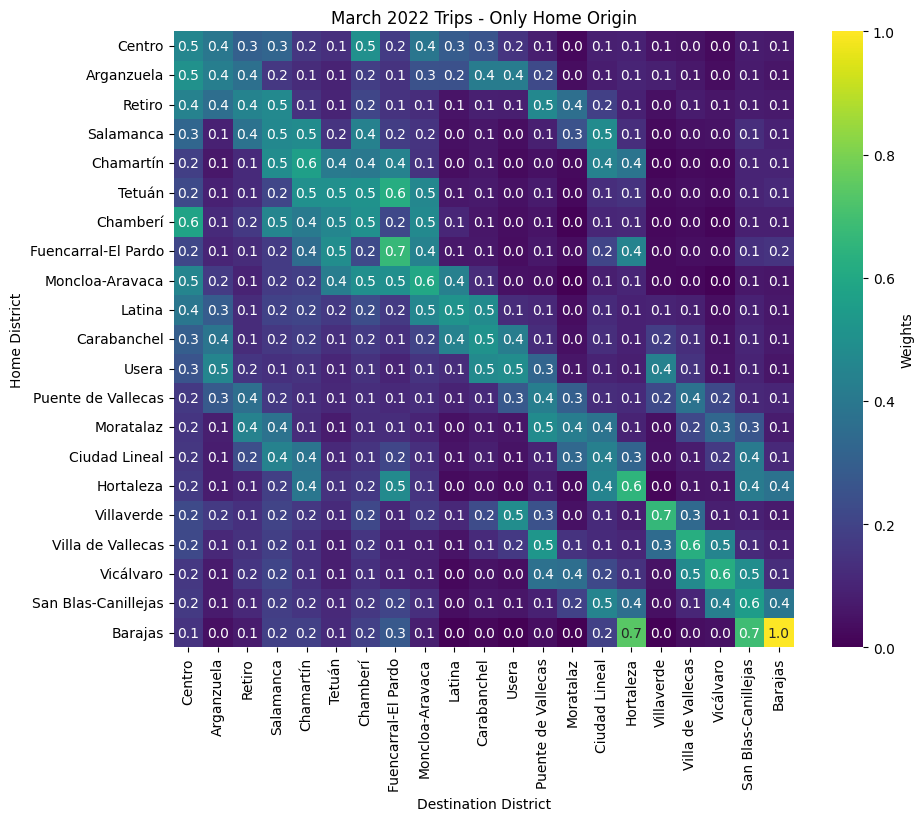

In [29]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    adj_matrix, 
    annot=True, 
    cmap='viridis', 
    cbar_kws={'label': 'Weights'}, 
    fmt=".1f"
)
plt.title('March 2022 Trips - Only Home Origin')
plt.xlabel('Destination District')
plt.ylabel('Home District');

In [21]:
trip_counts.to_csv('outputs/trip_counts.csv', index=False)

## Testing Infomap

In [ ]:
edges_with_weights = [(u, v, data['weight']) for u, v, data in G.edges(data=True)]

df_edges = pd.DataFrame(edges_with_weights, columns=['source', 'target', 'weight'])
df_edges = df_edges[df_edges['weight'] >= 0.3] # NOTE: Infomap only finds 1 community if I leave edges as they are. Hence, I had to cut edges 

df_edges.to_csv('infomap_input.txt', sep=' ', header=False, index=False)

In [ ]:
df_edges

## Community Analysis

In [ ]:
communities = nx.community.louvain_communities(G, weight='weight', seed=1234)

In [ ]:
len(communities)

In [ ]:
def average_degree_per_community(G, communities):
    community_avg_in_degrees = []
    community_avg_out_degrees = []
    
    for community in communities:
        in_degrees = [G.in_degree(node,  weight='weight') for node in community]  # Get in-degree for each node
        out_degrees = [G.out_degree(node,  weight='weight') for node in community] 
        avg_in_degree = sum(in_degrees) / len(community)        # Compute average in-degree
        avg_out_degree = sum(out_degrees) / len(community)
        community_avg_in_degrees.append(avg_in_degree)
        community_avg_out_degrees.append(avg_out_degree)
        print(f"Community {community} - Average In-degree: {avg_in_degree} - Average Out-degree: {avg_out_degree}")
    
    return community_avg_in_degrees, community_avg_out_degrees

# Calculate and display average in-degree for each community
average_degree_per_community(G, communities)